[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Data Preview:
  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

Label Distribution:
label
ham     4825
spam     747
Name: count, dtype: int64

Best Parameters: {'alpha': 0.5}

Accuracy: 0.9757847533632287

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       965
           1       1.00      0.82      0.90       150

    accuracy                           0.98      1115
   macro avg       0.99      0.91      0.94      1115
weighted avg       0.98      0.98      0.97      1115



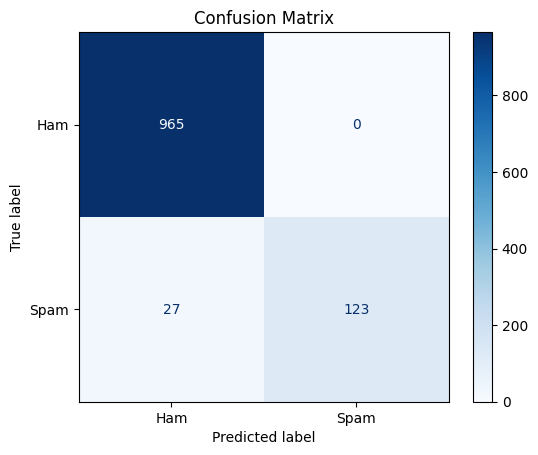


Example Predictions:
Text: Congratulations, you've won a $1000 gift card! Call now.
Prediction: Spam

Text: Meeting at 10am tomorrow.
Prediction: Ham



In [ ]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import joblib

# Download NLTK stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

# Load data
data = pd.read_csv('spam.csv', encoding='latin-1')
data = data[['v1', 'v2']]  # Keep relevant columns
data.columns = ['label', 'text']  # Rename columns

# Inspect data
print("Data Preview:")
print(data.head())
print("\nLabel Distribution:")
print(data['label'].value_counts())

# Preprocessing
def preprocess_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    return text

data['text'] = data['text'].apply(preprocess_text)

# Encode labels
label_mapping = {'ham': 0, 'spam': 1}
data['label'] = data['label'].map(label_mapping)

# Split data
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)

# Feature extraction
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Model training and hyperparameter tuning
model = MultinomialNB()
parameters = {'alpha': [0.1, 0.5, 1.0, 2.0]}
clf = GridSearchCV(model, parameters, cv=5)
clf.fit(X_train_vec, y_train)

# Best parameters and model
print("\nBest Parameters:", clf.best_params_)
model = clf.best_estimator_

# Predictions
y_pred = model.predict(X_test_vec)

# Evaluate
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
labels = sorted(set(y_test))  # Ensure labels are integers and sorted
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Save model and vectorizer
joblib.dump(model, 'spam_classifier.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

# Load model and vectorizer (for testing)
model = joblib.load('spam_classifier.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Example usage
example_texts = ["Congratulations, you've won a $1000 gift card! Call now.", "Meeting at 10am tomorrow."]
example_texts_vec = vectorizer.transform(example_texts)
predictions = model.predict(example_texts_vec)
print("\nExample Predictions:")
for text, label in zip(example_texts, predictions):
    print(f"Text: {text}\nPrediction: {'Spam' if label == 1 else 'Ham'}\n")
